## Import Packages

In [26]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
# tf_device='/gpu:0'import time
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))


import matplotlib.pyplot as plt
import pandas as pd
from random import random, randint
from tensorflow.keras import layers
from tensorflow.keras import backend as k
from IPython.display import clear_output
import time
from tqdm import tqdm
import numpy as np
import tensorflow_datasets as tfds

print("Import Complete")

2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Import Complete


In [27]:
## Load Data

In [28]:
BATCH_SIZE = 64

def get_mnist_dataset():
        """Retrieve MNIST Digits dataset from tfds. Normalise, shuffle and batch the dataset."""
        dataloader = tfds.load('mnist', as_supervised=True)
        dataset = dataloader['train']
        # Cast [0,255] images to [-1,1].
        dataset = dataset.map(lambda image, label: layers.experimental.preprocessing.Rescaling(scale=1. / 127.5, offset=-1)(image))
        dataset = dataset.shuffle(BATCH_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
        print('MNIST Digits dataset loaded.')
        return dataset

## Preprocess Images
### Normalization

In [29]:
train_ds = get_mnist_dataset()

MNIST Digits dataset loaded.


In [30]:
generator = tf.keras.models.Sequential()
generator.add(layers.Input((100,)))
generator.add(layers.Dense(7*7*32))
generator.add(layers.Reshape((7, 7, 32)))
generator.add(layers.Conv2D(32, (3, 3), padding="same"))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(32, (3, 3), padding="same"))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(32, (3, 3), padding="same"))
generator.add(layers.Dense(1, activation="tanh"))

print(generator.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1568)              158368    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)       

In [31]:
IMAGE_SIZE = 28

discriminator = tf.keras.models.Sequential()

discriminator.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.2))

discriminator.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.2))

# discriminator.add(layers.Conv2D(IMAGE_SIZE * 4, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]))
# discriminator.add(layers.LeakyReLU())
# discriminator.add(layers.Dropout(0.2))
#
# discriminator.add(layers.Conv2D(IMAGE_SIZE * 8, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]))
# discriminator.add(layers.LeakyReLU())
# discriminator.add(layers.Dropout(0.2))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation="sigmoid"))

print(discriminator.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1568)             

In [32]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    realLoss = cross_entropy(tf.ones_like(real_output), real_output)
    fakeLoss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return realLoss + fakeLoss

def generator_loss(fakeOutput):
    return cross_entropy(tf.ones_like(fakeOutput), fakeOutput)

In [33]:
generatorOptimizer = tf.keras.optimizers.Adam(1e-4)
discriminatorOptimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
@tf.function
def train_step(images):
    latent = tf.random.normal((BATCH_SIZE, 100))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(latent, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        genLoss = generator_loss(fake_output)
        discLoss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(genLoss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(discLoss, discriminator.trainable_variables)

    generatorOptimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminatorOptimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return genLoss, discLoss

In [35]:
NUM_SAMPLES_TO_GENERATE = 8
seed = tf.random.normal([NUM_SAMPLES_TO_GENERATE, 100])

In [36]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 4), constrained_layout=True)

    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i + 1)
        plt.imshow((predictions[i].numpy()), cmap="gray")
        plt.axis("off")

    plt.show()

def train(dataset, epochs):
    history = {
        'gen_loss': [],
        'disc_loss': []
    }

    generate_and_save_images(generator, 0, seed)

    for epoch in range(epochs):
        start = time.time()

        gen_loss = []
        disc_loss = []
        for image_batch in tqdm(dataset):
            h = train_step(image_batch)
            gen_loss.append(h[0])
            disc_loss.append(h[1])
        history['gen_loss'].append(sum(gen_loss))
        history['disc_loss'].append(sum(disc_loss))
        print(f"EPOCH: {epoch}\ngen_loss: {sum(gen_loss)}\ndisc_loss: {sum(disc_loss)}")

        # Produce images for the GIF as you go
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        print("Time for epoch {} is {} sec".format(epoch + 1, time.time() - start))

    return history

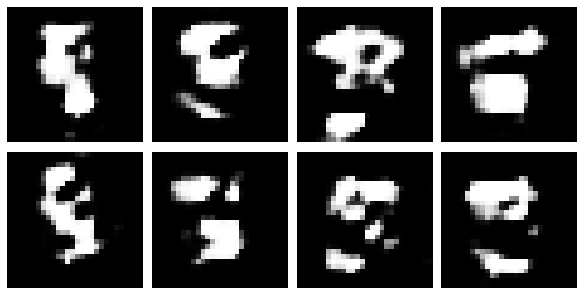

Time for epoch 5 is 9.516998291015625 sec
Finished


In [37]:
EPOCHS = 5

print("Starting")
history = train(train_ds, EPOCHS)
print("Finished")